In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras import backend as K

In [2]:
new_df = pd.read_csv("../data/new_df.csv")
new_df.drop(columns = 'Unnamed: 0', inplace=True)

In [3]:
#normalizing
scaler = StandardScaler()
new_df.iloc[:, 6:496] = scaler.fit_transform(new_df.iloc[:, 6:496])

## Density diagarams of the different variables per class

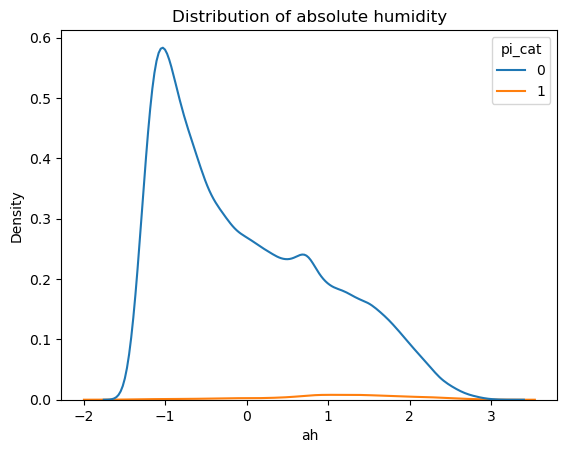

In [4]:
new_df.pi_cat = np.where(new_df.pi24>15,1,0)

sns.kdeplot(data=new_df, x= "ah", hue = "pi_cat").set(title='Distribution of absolute humidity')
plt.savefig('pics.png', dpi=300)

In [5]:
split_index = round(new_df.shape[0] * 0.8)

test = new_df[split_index:]
train = new_df[:split_index]

# KNN

In [6]:
%%time
# KNN
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine', n_jobs=-1)

KNN.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])


CPU times: total: 62.5 ms
Wall time: 75.6 ms


KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=1)

In [7]:
%%time
preds = KNN.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]].values)

KNN_proba = KNN.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]].values)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


CPU times: total: 12min 48s
Wall time: 7min 30s


In [8]:
confusion_matrix(test.loc[:, 'pi_cat'], preds)

array([[33592,   568],
       [  650,   156]], dtype=int64)

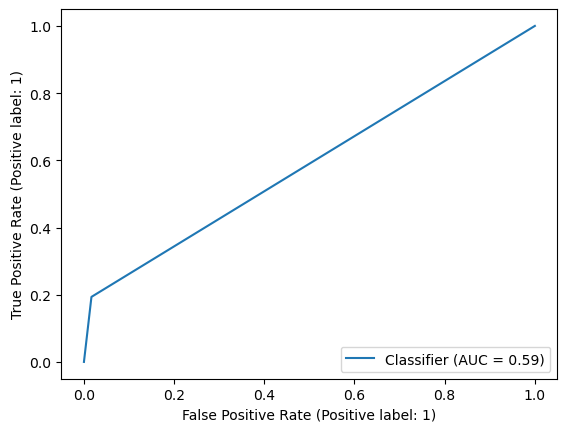

In [9]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], KNN_proba[:,1])
plt.show()

In [10]:
f1_score(test.loc[:, 'pi_cat'], preds)

0.203921568627451

In [11]:
accuracy_score(test.loc[:, 'pi_cat'], preds)

0.965166161413945

# Random Forest

In [12]:
RF = RandomForestClassifier(n_jobs= -1, class_weight=None)

RF.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])

RandomForestClassifier(n_jobs=-1)

In [13]:
RF.feature_importances_

array([0.03287813, 0.04622437, 0.02788215, 0.0400951 , 0.0372701 ,
       0.05064114, 0.08098894, 0.03031515, 0.03986263, 0.02641048,
       0.03637508, 0.03233021, 0.03971289, 0.03321195, 0.02987722,
       0.03910566, 0.02591283, 0.03467082, 0.03185667, 0.03820856,
       0.01685821, 0.03294556, 0.03842976, 0.02776477, 0.03703045,
       0.03450594, 0.04360491, 0.01503034])

In [14]:
RF_preds = RF.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])
RF_proba = RF.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])


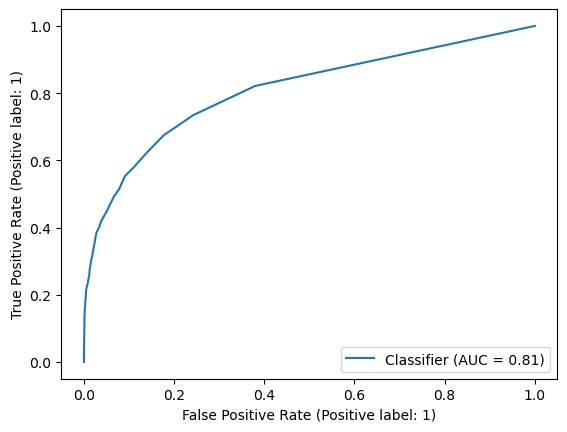

In [15]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], RF_proba[:,1])
plt.savefig('rf_roc.png', dpi=300)

In [16]:
confusion_matrix(test.loc[:, 'pi_cat'], RF_preds)

array([[34120,    40],
       [  698,   108]], dtype=int64)

In [17]:
f1_score(test.loc[:, 'pi_cat'], RF_preds)
# accuracy_score(test.loc[:, 'pi_cat'], RF_preds)

0.2264150943396226

# LightGBM

In [18]:
parameters = {'boosting_type':['dart'], 
              'learning_rate':[.3,.4,.5, .6],
              'n_jobs': [-1],
              'class_weight': ['balanced']}

lgbmc = LGBMClassifier()

clf = GridSearchCV(lgbmc, 
                   parameters, 
                   scoring= 'f1',
                   n_jobs=-1)

lgbm_fit = clf.fit(X = train.iloc[:, 6:106], y = train.loc[:, 'pi_cat'])

[LightGBM] [Info] Number of positive: 2142, number of negative: 137723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23760
[LightGBM] [Info] Number of data points in the train set: 139865, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [19]:
pd.DataFrame(lgbm_fit.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score
1,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.239211,1
0,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.238548,2
2,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.235697,3
3,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.227160,4


In [20]:
lgbmc = LGBMClassifier(boosting_type='dart', learning_rate=.4, n_jobs=-1, class_weight='balanced')

lgbmc.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])

[LightGBM] [Info] Number of positive: 2142, number of negative: 137723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6444
[LightGBM] [Info] Number of data points in the train set: 139865, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.4,
               n_jobs=-1)

In [21]:
LG_preds = lgbmc.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [22]:
LG_proba = lgbmc.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [23]:
confusion_matrix(test.loc[:, 'pi_cat'], LG_preds)

array([[32312,  1848],
       [  442,   364]], dtype=int64)

In [24]:
f1_score(test.loc[:, 'pi_cat'], LG_preds)

0.24121935056328692

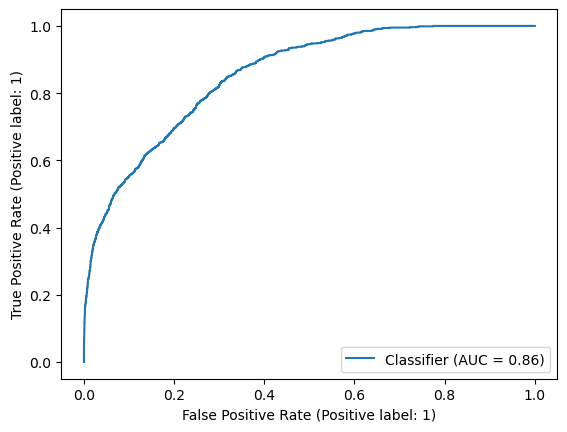

In [25]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], LG_proba[:,1])
plt.savefig('lgbm_roc.png', dpi=300)

# GRU

In [27]:
X = np.array(train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(train.shape[0],-1, 7)
y = np.array(train['pi_cat'])

In [28]:
X_test = np.array(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(test.shape[0],-1,7)
y_test = np.array(test['pi_cat'])

In [29]:
class_weights = {0: 1., 1: 70.}
grumod = Sequential()

grumod.add(LSTM(units = 10, return_sequences = True, input_shape = (4, 7)))
grumod.add(Dropout(0.2))

grumod.add(LSTM(units = 3, return_sequences = False))
grumod.add(Dropout(0.2))

grumod.add(Dense(units = 1, activation='sigmoid'))

grumod.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = grumod.fit(X, train.pi_cat, validation_data=(X_test,test.pi_cat), epochs = 50, batch_size = 512, class_weight = class_weights)

Epoch 1/50
274/274 [==============================] - 14s 21ms/step - loss: 1.1378 - val_loss: 0.5915
Epoch 2/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8997 - val_loss: 0.5009
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8471 - val_loss: 0.4816
Epoch 4/50
274/274 [==============================] - 5s 17ms/step - loss: 0.8278 - val_loss: 0.5228
Epoch 5/50
274/274 [==============================] - 4s 15ms/step - loss: 0.8008 - val_loss: 0.4676
Epoch 6/50
274/274 [==============================] - 4s 15ms/step - loss: 0.7841 - val_loss: 0.4560
Epoch 7/50
274/274 [==============================] - 4s 14ms/step - loss: 0.7768 - val_loss: 0.4595
Epoch 8/50
274/274 [==============================] - 4s 14ms/step - loss: 0.7622 - val_loss: 0.4876
Epoch 9/50
274/274 [==============================] - 4s 14ms/step - loss: 0.7583 - val_loss: 0.4806
Epoch 10/50
274/274 [==============================] - 4s 16ms/step - loss: 0.7510 - val_l

In [30]:
gru_preds = grumod.predict(X_test[:,:10,:])

1093/1093 [==============================] - 6s 4ms/step


In [31]:
confusion_matrix(test.pi_cat,np.round(gru_preds))

array([[28297,  5863],
       [  276,   530]], dtype=int64)

In [32]:
f1_score(test.pi_cat,np.round(gru_preds))

0.14724267259341575

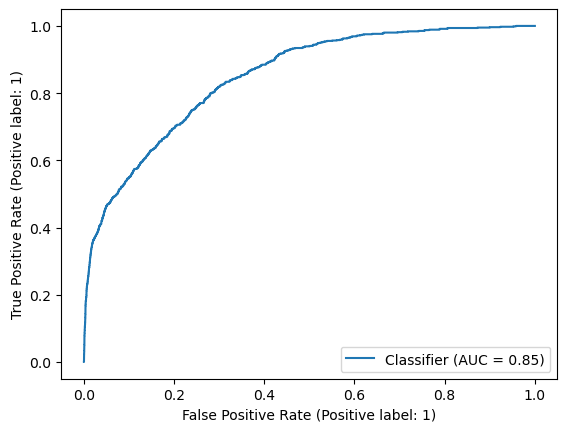

In [33]:
RocCurveDisplay.from_predictions(test.pi_cat,gru_preds)
plt.savefig('gru_roc.png', dpi=300)